# Estimation of Navier-Stokes equation

In this project I aim at developing a PINN for estimation of the 2D Navier-Stokes equation.

# Imports and dependencies and whatnot

In [2]:
!pip install deepxde

In [3]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

No backend selected.
Finding available backend...
Found tensorflow
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



# Parameters

In [4]:
rho = 1  # Density
mu = 0.005   # Viscosity
u_in = 1
D = 1
L = 2
t_0 = 0
t_1 = 1

# TimePDE setup
num_domain=10000
num_boundary=5000
num_initial=1000

# Data pipeline

## Definition of the geometry

In [5]:
channel = dde.geometry.Rectangle(xmin=[-L / 2, -D / 2], xmax=[L / 2, D / 2])
cylinder = dde.geometry.Disk([0, 0], 0.1)

geom_space = channel - cylinder

geom_time = dde.geometry.TimeDomain(t_0, t_1)
geom = dde.geometry.GeometryXTime(geom_space, geom_time)

## PDE function
Defining the navier-stokes equation

In [6]:
def pde(x, y):
    u = y[:, 0:1]
    v = y[:, 1:2]
    p = y[:, 2:3]

    u_x = dde.grad.jacobian(y, x, i=0, j=0)
    u_y = dde.grad.jacobian(y, x, i=0, j=1)
    u_t = dde.grad.jacobian(y, x, i=0, j=2)

    v_x = dde.grad.jacobian(y, x, i=1, j=0)
    v_y = dde.grad.jacobian(y, x, i=1, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=2)

    p_x = dde.grad.jacobian(y, x, i=2, j=0)
    p_y = dde.grad.jacobian(y, x, i=2, j=1)

    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    u_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)

    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    v_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)

    continuity = u_x + v_y

    mom_u = u_t + u * u_x + v * u_y + p_x / rho - mu * (u_xx + u_yy)
    mom_v = v_t + u * v_x + v * v_y + p_y / rho - mu * (v_xx + v_yy)

    return [continuity, mom_u, mom_v]

## Boundary conditions as well as the inlet profile function

In [7]:
def inlet_boundary(x, on_boundary):
    return on_boundary and np.isclose(x[0], -L / 2)

def outlet_boundary(x, on_boundary):
    return on_boundary and np.isclose(x[0], L / 2)

def top_bottom_boundary(x, on_boundary):
    return on_boundary and (np.isclose(x[1], D / 2) or np.isclose(x[1], -D / 2))

def cylinder_boundary(x, on_boundary):
    return on_boundary and (x[0] ** 2 + x[1] ** 2 <= (0.1 + 1e-6) ** 2)

def inlet_u(x):
    y = x[:, 1:2]
    return 4 * u_in * (y + D / 2) * (D / 2 - y) / D ** 2

In [8]:
bc_inlet_u = dde.DirichletBC(geom, inlet_u, inlet_boundary, component=0)
bc_inlet_v = dde.DirichletBC(geom, lambda x: 0.0, inlet_boundary, component=1)

bc_wall_u = dde.DirichletBC(geom, lambda x: 0.0, top_bottom_boundary, component=0)
bc_wall_v = dde.DirichletBC(geom, lambda x: 0.0, top_bottom_boundary, component=1)

bc_cyl_u = dde.DirichletBC(geom, lambda x: 0.0, cylinder_boundary, component=0)
bc_cyl_v = dde.DirichletBC(geom, lambda x: 0.0, cylinder_boundary, component=1)

bc_outlet_p = dde.DirichletBC(geom, lambda x: 0.0, outlet_boundary, component=2)

ic_u = dde.IC(geom, lambda x: 0.0, lambda x, on_initial: on_initial, component=0)
ic_v = dde.IC(geom, lambda x: 0.0, lambda x, on_initial: on_initial, component=1)
ic_p = dde.IC(geom, lambda x: 0.0, lambda x, on_initial: on_initial, component=2)

bcs = [bc_inlet_u, bc_inlet_v, bc_wall_u, bc_wall_v, bc_cyl_u, bc_cyl_v, bc_outlet_p, ic_u, ic_v, ic_p]

## Data generation

In [9]:
data = dde.data.TimePDE(
    geom,
    pde,
    bcs,
    num_domain=num_domain,
    num_boundary=num_boundary,
    num_initial=num_initial
)

# Neural Network

## Defining the neural network

The size `[3] + [64] * 3 + [3]` has proven to be the most efficient for the usecase. The difference between activation functions is negligible so I have settled at tanh

In [10]:
net = dde.maps.FNN([3] + [64] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)

## Training

We are training for 40000 epochs

In [11]:
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=40000)

Compiling model...
'compile' took 0.316983 s

Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
0         [7.34e-02, 1.65e-02, 3.73e-01, 3.94e-01, 3.51e-02, 1.08e-02, 1.48e-01, 2.46e-03, 1.09e-01, 2.63e-02, 4.54e-03, 4.82e-02, 9.37e-04]    [7.34e-02, 1.65e-02, 3.73e-01, 3.94e-01, 3.51e-02, 1.08e-02, 1.48e-01, 2.46e-03, 1.09e-01, 2.63e-02, 4.54e-03, 4.82e-02, 9.37e-04]    []  
1000      [1.52e-02, 3.06e-03, 1.12e-03, 2.53e-02, 3.20e-03, 1.16e-03, 1.42e-02, 2.08e-03, 4.53e-04, 5.63e-05, 2.49e-02, 4.49e-03, 4.49e-04]    [1.52e-02, 3.06e-03, 1.12e-03, 2.53e-02, 3.20e-03, 1.16e-03, 1.42e-02, 2.08e-03, 4.53e-04, 5.63e-05, 2.49e-02, 4.49e-03, 4.49e-04]    []  
2000      [1.24e-02, 2.76e-03, 1.26e-03, 2.00e-02, 1.49e-03, 9.90e-04, 1.68e-02

When we want to load the NN from a file for some reason we have to run the training for a tiny bit for the network to be built and then we can load the weights

In [ ]:
#model.restore("navier_stokes_pinn-45000.weights.h5")

In [12]:
model.save("navier_stokes_pinn")

'navier_stokes_pinn-40000.weights.h5'

Plotting the graphs of all the losses (train and test)

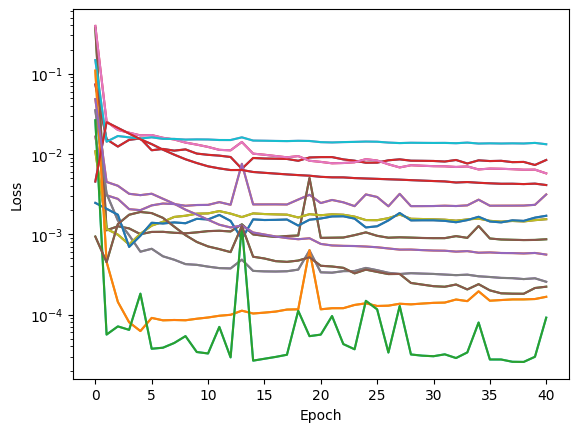

In [15]:
plt.figure()
plt.plot(losshistory.loss_train, label="train")
plt.plot(losshistory.loss_test, label="test")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Evaluation

L2 residuals are MSE of the residual errors. The less it is the better.

In [16]:
X_test, y_test, *_ = data.test()

f_pred = model.predict(X_test, operator=pde)  # list of arrays
f_pred = np.hstack(f_pred)  # shape (N, 3)

residual_l2 = np.sqrt(np.mean(f_pred**2, axis=0))
residual_l2_total = np.sqrt(np.mean(f_pred**2))

print("L2 residual per equation:", residual_l2)
print("Total L2 residual:", residual_l2_total)

L2 residual per equation: [0.07511157 0.05598856 0.02720737]
Total L2 residual: 0.05632272


The plot of the error per area on the graph

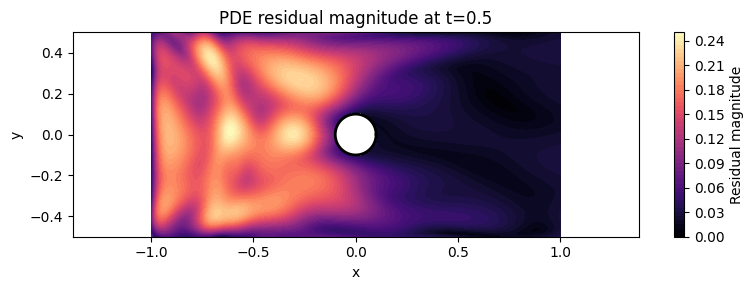

In [20]:
t_plot = 0.5
nx, ny = 200, 100
x = np.linspace(-L/2, L/2, nx)
y = np.linspace(-D/2, D/2, ny)
X, Y = np.meshgrid(x, y)

XYT = np.vstack([X.ravel(), Y.ravel(), t_plot*np.ones_like(X.ravel())]).T

f_pred = model.predict(XYT, operator=pde)
f_pred = np.hstack(f_pred)

res_mag = np.sqrt(np.sum(f_pred**2, axis=1)).reshape(ny, nx)

R = 0.1
mask = (X**2 + Y**2) <= R**2
res_mag = np.ma.array(res_mag, mask=mask)

plt.figure(figsize=(8, 3))
plt.contourf(X, Y, res_mag, levels=50, cmap="magma")
plt.colorbar(label="Residual magnitude")

theta = np.linspace(0, 2*np.pi, 200)
plt.plot(R*np.cos(theta), R*np.sin(theta), "k", linewidth=2)

plt.xlabel("x")
plt.ylabel("y")
plt.title(f"PDE residual magnitude at t={t_plot}")
plt.axis("equal")
plt.tight_layout()
plt.show()

# Visualization

In [18]:
import matplotlib.animation as animation
from matplotlib. patches import Circle

In [ ]:
nx, ny = 200, 100
x = np.linspace(-L/2, L/2, nx)
y = np.linspace(-D/2, D/2, ny)
X, Y = np.meshgrid(x, y)
XY = np.vstack([X.ravel(), Y.ravel()]).T

n_frames = 900
t_vals = np.linspace(t_0, t_1, n_frames)

R = 0.1
cyl_mask = (X**2 + Y**2) <= R**2

def get_flow_data_at_t(t):
    """Get velocity components and speed at time t"""
    t_col = np.full((XY.shape[0], 1), t)
    XYT = np. hstack([XY, t_col])
    pred = model.predict(XYT)
    u = pred[:, 0]. reshape(ny, nx)
    v = pred[:, 1]. reshape(ny, nx)
    speed = np.sqrt(u**2 + v**2)
    u = np.where(cyl_mask, np.nan, u)
    v = np.where(cyl_mask, np.nan, v)
    speed = np.where(cyl_mask, np. nan, speed)
    return u, v, speed

flow_data = [get_flow_data_at_t(t) for t in t_vals]
speeds = [data[2] for data in flow_data]
vmin = min(np.nanmin(s) for s in speeds)
vmax = max(np.nanmax(s) for s in speeds)

fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim(-L/2, L/2)
ax.set_ylim(-D/2, D/2)
ax.set_aspect('equal')
title = ax.set_title(f"Speed magnitude with streamlines, t={t_vals[0]:.2f}")

cyl = Circle((0, 0), R, edgecolor="black", facecolor="white", zorder=10)
ax.add_patch(cyl)

u0, v0, speed0 = flow_data[0]
cax = ax.contourf(X, Y, speed0, levels=50, cmap="jet", vmin=vmin, vmax=vmax)
cb = fig.colorbar(cax, ax=ax)
cb.set_label("Speed magnitude")

stream = ax.streamplot(X, Y, u0, v0, color='white', linewidth=0.6,
                        density=1.5, arrowsize=0.8, arrowstyle='->')

def update(frame):
    for coll in list(ax.collections):
        coll.remove()
    for patch in list(ax.patches):
        if not isinstance(patch, Circle):
            patch.remove()

    u, v, speed = flow_data[frame]

    ax.contourf(X, Y, speed, levels=50, cmap="jet", vmin=vmin, vmax=vmax)

    n_lines = 25 # !!!!
    start_y = np.linspace(-D/2 + 0.05, D/2 - 0.05, n_lines)
    start_x = np.full_like(start_y, -L/2 + 0.01)
    start_points = np.column_stack([start_x, start_y])

    ax.streamplot(X, Y, u, v, color='white', linewidth=0.8,
              start_points=start_points, arrowsize=0.8, arrowstyle='->')

    cyl = Circle((0, 0), R, edgecolor="black", facecolor="white", zorder=10)
    ax.add_patch(cyl)

    title.set_text(f"Speed magnitude with streamlines, t={t_vals[frame]:.2f}")
    return None

ani = animation.FuncAnimation(fig, update, frames=n_frames, blit=False)

ani.save("animation.mp4", writer="ffmpeg", dpi=300, fps=60)
plt.close(fig)